In [31]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from PIL import Image, UnidentifiedImageError
import uuid

In [64]:
# Define organized dataset directory
organized_dataset_path = "/Users/mani/Sneakers_Organized"
nike_organized_path = os.path.join(organized_dataset_path, "Nike")
other_organized_path = os.path.join(organized_dataset_path, "Other")
non_shoe_path = os.path.join(organized_dataset_path, "non_shoe")

# Data Preparation

This section defines the dataset directories and initializes the `ImageDataGenerator` with augmentation techniques.
We apply **MobileNetV2 preprocessing**, **rotation, brightness adjustments, and flipping** to improve generalization.

- `train_generator` is used for training images.
- `val_generator` is used for validation images.
- `test_generator` is used to evaluate model performance.


In [84]:
# Define ImageDataGenerator with MobileNetV2 preprocessing
data_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    brightness_range=[0.7, 1.3],
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    channel_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)


# Create training and validation generators
train_generator = data_gen.flow_from_directory(
    organized_dataset_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    classes=['Nike', 'Other', 'non_shoe']  # Multi-class classification
)

val_generator = data_gen.flow_from_directory(
    organized_dataset_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    classes=['Nike', 'Other', 'non_shoe']  # Ensure validation has the same class mapping
)

Found 31976 images belonging to 3 classes.
Found 7993 images belonging to 3 classes.


In [87]:
# Verify class mapping
print(train_generator.class_indices)  # Should output {'Nike': 0, 'Other': 1}


{'Nike': 0, 'Other': 1, 'non_shoe': 2}


# Loading Pre-Trained MobileNetV2

We load the **MobileNetV2** model with pre-trained **ImageNet** weights.
- The first **100 layers are frozen** to retain learned features.
- A custom classification head is added to predict **Nike, Other, and Non-Shoe** categories.


In [90]:
# Load pre-trained MobileNetV2 model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model.trainable = True
for layer in base_model.layers[:120]:  # Freeze first 100 layers
    layer.trainable = False

# Model Architecture

We define a **CNN model** using the pre-trained **MobileNetV2** as a feature extractor.
- Added **Batch Normalization** and **Dropout layers** to prevent overfitting.
- **Softmax activation** is used to predict one of the three classes: **Nike, Other, or Non-Shoe**.


In [93]:
# Define the multi-class classification model
model = models.Sequential([
    base_model,
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.002)),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.002)),
    layers.Dropout(0.4),
    layers.Dense(3, activation='softmax')  # Multi-class classification
])

# Model Compilation

We use the **Adam optimizer** with **Exponential Decay learning rate** to improve training stability.
The loss function is **categorical_crossentropy** since this is a **multi-class classification problem**.


In [96]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',  # Multi-class loss function
              metrics=['accuracy'])

# Callbacks for Efficient Training

To optimize training, we use:
- **EarlyStopping**: Stops training if validation loss does not improve.
- **ReduceLROnPlateau**: Reduces the learning rate if training stagnates.
- **ModelCheckpoint**: Saves the best model based on validation loss.
- **TensorBoard**: Enables visualization of training logs.


In [99]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=4, min_lr=1e-6),
    tf.keras.callbacks.ModelCheckpoint("/Users/mani/nike_best_model.keras", monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir="./logs")
]

# Training the Model

We resume training from **epoch 17** and train for an additional **10 epochs**.
This ensures that the model continues learning from where it left off without overfitting.


In [102]:
# Resume training from epoch 17
initial_epoch = 17
epochs = 20
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=callbacks,
    initial_epoch=initial_epoch
)

Epoch 18/20
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 379s 188ms/step - accuracy: 0.7516 - loss: 2.4443 - val_accuracy: 0.8731 - val_loss: 1.5171 - learning_rate: 1.0000e-04
Epoch 19/20
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 366s 183ms/step - accuracy: 0.8870 - loss: 1.3107 - val_accuracy: 0.9020 - val_loss: 0.8059 - learning_rate: 1.0000e-04
Epoch 20/20
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 382s 191ms/step - accuracy: 0.9163 - loss: 0.6730 - val_accuracy: 0.9035 - val_loss: 0.4840 - learning_rate: 1.0000e-04


In [104]:
# Fine-tuning after initial training
for layer in base_model.layers:
    layer.trainable = True  # Unfreeze all layers
optimizer.learning_rate.assign(0.00005)  # Reduce learning rate for fine-tuning

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Additional fine-tuning epochs
    callbacks=callbacks
)

Epoch 1/10
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 379s 189ms/step - accuracy: 0.9381 - loss: 0.3722 - val_accuracy: 0.9338 - val_loss: 0.3284 - learning_rate: 5.0000e-05
Epoch 2/10
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 377s 189ms/step - accuracy: 0.9451 - loss: 0.2739 - val_accuracy: 0.9336 - val_loss: 0.2761 - learning_rate: 5.0000e-05
Epoch 3/10
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 367s 184ms/step - accuracy: 0.9521 - loss: 0.2133 - val_accuracy: 0.9356 - val_loss: 0.2280 - learning_rate: 5.0000e-05
Epoch 4/10
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 365s 183ms/step - accuracy: 0.9529 - loss: 0.1808 - val_accuracy: 0.9339 - val_loss: 0.2167 - learning_rate: 5.0000e-05
Epoch 5/10
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 368s 184ms/step - accuracy: 0.9590 - loss: 0.1511 - val_accuracy: 0.9436 - val_loss: 0.1803 - learning_rate: 5.0000e-05
Epoch 6/10
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 366s 183ms/step - accuracy: 0.9641 - loss: 0.1351 - val_accuracy: 0.9482 - val_loss: 0.1695 - learning_rate: 5.0000e-05
Epoch 7/10
1999/1999 ━━━━━━━

In [106]:
# Save the trained model
model.save("/Users/mani/nikeshoeornotshoe.h5")
print("Model saved successfully.")

Model saved successfully.


In [136]:
test_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_data_gen.flow_from_directory(
    "/Users/mani/Sneakers_Organized/test",
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False  # No need to shuffle for evaluation
)


Found 846 images belonging to 3 classes.


# Model Evaluation on Test Data

We evaluate the trained model on a **separate test set**.
The final test accuracy and loss are printed to assess model performance.


In [140]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.9129 - loss: 0.3336
Test Accuracy: 0.9291, Test Loss: 0.2566


# Saving the Model

The trained model is saved as **nike_final_model.keras** for future use.
This ensures that we don’t need to retrain the model from scratch.


In [146]:
# Save the final model
model.save("/Users/mani/nike_final_model.keras")
print("Model saved successfully!")

Model saved successfully!


# Making Predictions on New Images

A function `predict_image()` is defined to classify new images.
Simply pass an image path to the function, and it will return:
- The **predicted class** (Nike, Other, or Non-Shoe).
- The **confidence scores** for each class.


In [148]:
# Function to predict an image
def predict_image(img_path, model):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    
    predictions = model.predict(img_array)
    class_idx = np.argmax(predictions)
    class_labels = ['Nike', 'Other', 'Non-Shoe']
    return class_labels[class_idx], predictions


# Visualizing Training Performance

To analyze the model’s training process, we **plot accuracy and loss**:
- **Train vs. Validation Accuracy**
- **Train vs. Validation Loss**

This helps to assess whether the model is **overfitting** or **generalizing well**.


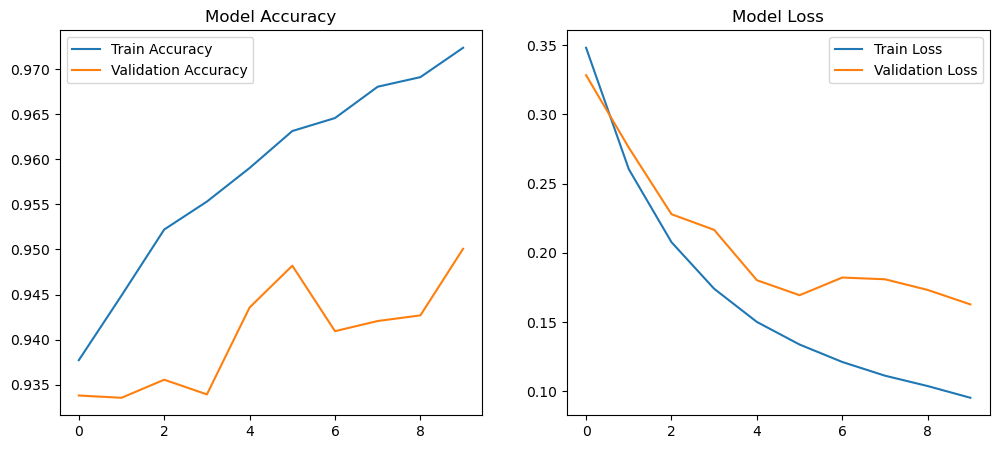

Model training and evaluation complete.


In [150]:
# Plot accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

print("Model training and evaluation complete.")


# Training Performance Analysis

These graphs illustrate the **training and validation accuracy** and **loss trends** over epochs:

- **Left (Model Accuracy)**: 
  - The **training accuracy** (blue) increases steadily.
  - The **validation accuracy** (orange) fluctuates but improves, indicating better generalization.

- **Right (Model Loss)**:
  - The **training loss** (blue) decreases consistently.
  - The **validation loss** (orange) shows an overall decline, confirming effective learning.

A small gap between training and validation performance suggests that the model is **not significantly overfitting**.


# Model Evaluation - Confusion Matrix & Classification Report

The confusion matrix and classification report provide a detailed **breakdown of predictions** across classes:

- **Diagonal cells (darker blue)** show correctly classified samples.
- **Off-diagonal cells (lighter blue)** indicate misclassifications.


53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step


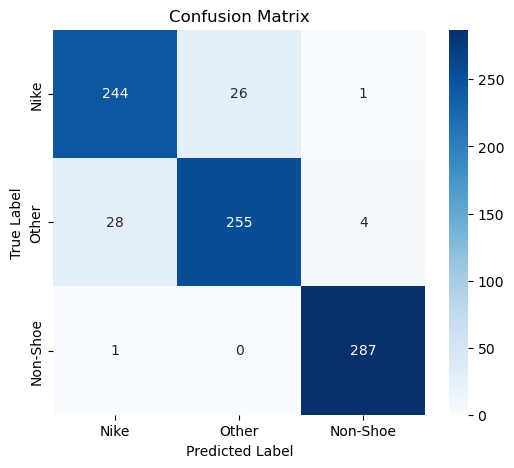

              precision    recall  f1-score   support

        Nike       0.89      0.90      0.90       271
       Other       0.91      0.89      0.90       287
    Non-Shoe       0.98      1.00      0.99       288

    accuracy                           0.93       846
   macro avg       0.93      0.93      0.93       846
weighted avg       0.93      0.93      0.93       846



In [144]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


# Get true labels and predictions
true_labels = test_generator.classes
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
class_labels = ['Nike', 'Other', 'Non-Shoe']

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print(classification_report(true_labels, predicted_labels, target_names=class_labels))


### **Key Insights from Classification Report:**
✅ **Nike Class**  
   - **Precision: 89%** (Out of all Nike predictions, 89% were correct)  
   - **Recall: 90%** (Out of all actual Nike samples, 90% were identified correctly)  

✅ **Other Class**  
   - **Precision: 91%**, **Recall: 89%**  

✅ **Non-Shoe Class**  
   - **Excellent classification** with **98% Precision and 100% Recall**, meaning nearly all Non-Shoe images were classified correctly.

### **Overall Model Performance:**
- **Accuracy: 93%** – A strong performance across all categories.
- **Balanced Precision, Recall, and F1-Scores** indicate reliable classification.

The model performs **exceptionally well on distinguishing shoes from non-shoes** but has minor misclassification between **Nike and Other brands**.